# Short Strangle

### I. Strategy Overview

* This strategy is composed of 2 short legs:
    * 1 OTM call option typically set around 10-15 delta with <15% ITM by expiration
    * 1 OTM put option typically set around 10-15 delta with <15% ITM by expiration
* This is a high probability strategy with large buying power requirement

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

![](short_strangle.jpg)

#### Features （Optional):
* Undefined risk strategy
* Delta Neutral: strategy profits if stock price expires between the strikes
* Long Theta: profit of the strategy increases as time decays
* Short volatility: profit of the strategy increases as the implied volatility drops

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta

####  a. Select underlying by ticker

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


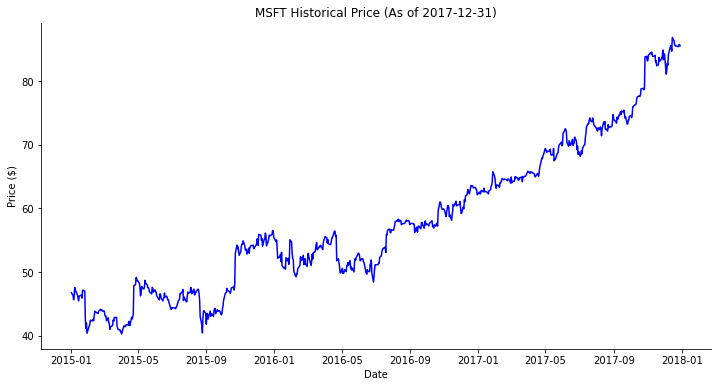

In [2]:
Ticker = 'MSFT'
GetPriceHistory(Ticker).plot_price_history()

#### b. Find expiration dates for testing period

In [3]:
Start_Date = datetime.datetime(2018, 1, 4)
End_Date = datetime.datetime(2018,6, 30)

GetDays(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2018-01-19,Friday,2018-01,1
1,2018-02-16,Friday,2018-02,1
2,2018-03-16,Friday,2018-03,1
3,2018-04-20,Friday,2018-04,1
4,2018-05-18,Friday,2018-05,1
5,2018-06-15,Friday,2018-06,1


#### c. Select an expiration date, choose option type (call) and strike price

In [22]:
expiration = datetime.datetime(2018, 3, 18)
option_type = ['P', 'C']  # C(all), P(ut)
action = ['S', 'S']  #L(ong), S(hort)

# Change the strike price to see how it affects the strategy
strike_price = [80, 90]  

#### d. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2018, 1, 2)
exit_date = datetime.datetime(2018, 3, 5)

### III. Visualization
#### a. Generate option(s) price and payoff

Option Premium = $0.91


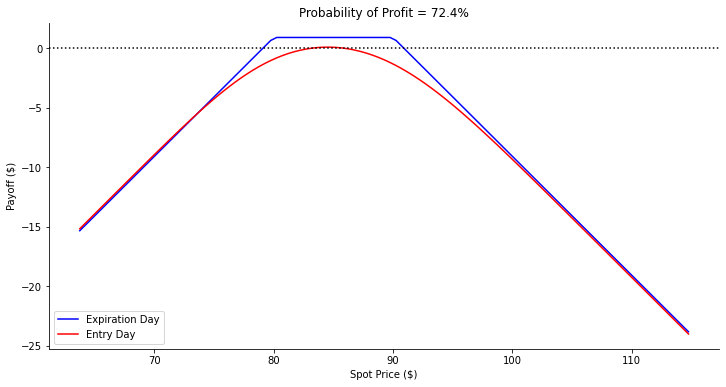

In [9]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[0] + payoff.option_price[1]))
payoff.plot_payoff()

#### * Probability of profit here is incorrect (needs more work)

##### b. Compare returns by holding the option vs. buy&hold the underlying

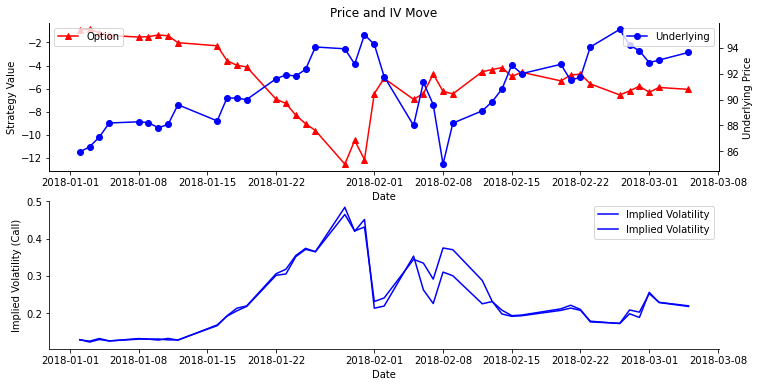

In [10]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

#### * 2 IV curves for put and call respectively.  Will retouch the plot later

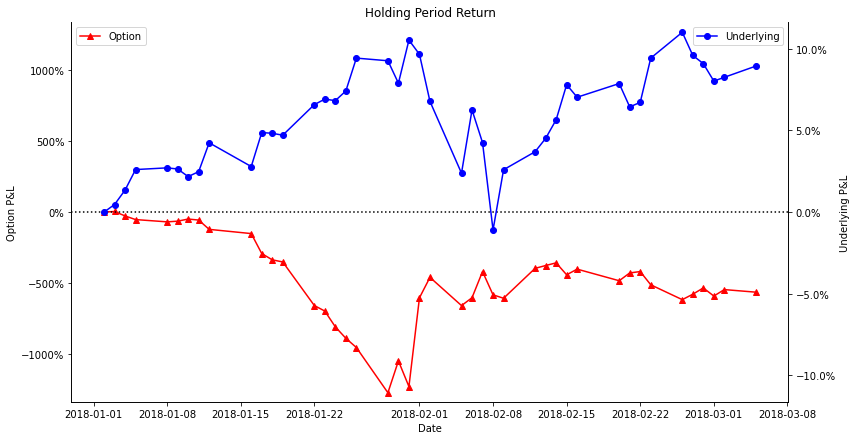

In [13]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [14]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-01-02,$-91.16,2018-03-05,62,$-606.56,$-515.40,$-8.31,-565.4%,False


### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [15]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices:
* Short put: enter day underlying price - \\$7.5
* Short Call: enter day underlying price + \\$7.5

In [16]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [17]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [32, 35]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-7.5, end_of_period_spot+7.5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [18]:
win_rate

'45.16%'

In [19]:
strategy_performance.reset_index(drop=True, inplace=True)
strategy_performance

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2016-01-07,$-482.35,2016-01-31,24,$-718.02,$-235.66,$-9.82,-48.9%,False
1,2016-02-04,$-58.14,2016-02-28,24,$-42.46,$15.68,$0.65,27.0%,True
2,2016-03-03,$-11.74,2016-03-27,24,$-12.28,$-0.55,$-0.02,-4.7%,False
3,2016-04-07,$-28.24,2016-05-01,24,$-33.72,$-5.48,$-0.23,-19.4%,False
4,2016-05-05,$-4.40,2016-05-29,24,$-2.84,$1.56,$0.07,35.5%,True
5,2016-06-02,$-1.04,2016-06-26,24,$-24.70,$-23.66,$-0.99,-2276.8%,False
6,2016-07-07,$-18.86,2016-07-31,24,$-78.35,$-59.49,$-2.48,-315.4%,False
7,2016-08-04,$-0.66,2016-08-28,24,$-1.76,$-1.10,$-0.05,-167.2%,False
8,2016-09-08,$-0.34,2016-10-02,24,$-0.48,$-0.15,$-0.01,-44.4%,False
9,2016-10-06,$-10.68,2016-10-30,24,$-14.21,$-3.53,$-0.15,-33.1%,False


#### *Note that for undefined risk strategies, cost = buying power effect substantial

In [21]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))

Total Profit:  $-1272.94
